In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
%matplotlib inline


import csv
import matplotlib.mlab as mlab
import os
import glob
%matplotlib inline
from scipy.optimize import curve_fit
from scipy.stats import chisquare
from scipy import optimize
from scipy.signal import savgol_filter
from readTRC import readTrc
from scipy.fftpack import rfft, irfft, fftfreq

In [2]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def find_vals(X,Y,cut):
    dataX = X[cut:]
    dataY = Y[cut:]
    minn = min(dataY)
    sig_val = minn*0.5
    MeanLoc = np.where(dataY==minn)[0][0]
    Mean = dataX[MeanLoc]
    L = dataY[0:MeanLoc]
    R = dataY[MeanLoc:len(dataY)]
    LP =find_nearest(L,sig_val)
    RP =find_nearest(R,sig_val)
    whereL = np.where(L==LP)[0][0]
    whereR = np.where(R==RP)[0][0]
    Lpoint = dataX[whereL]
    Rpoint = dataX[MeanLoc+whereR]
    FWHM = (Rpoint-Lpoint)   
    return (Mean,FWHM)

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [3]:
cd /Users/austinmcdonald/Desktop/data/Ion-stuff/Ion mobilitys/Argon/090718-bottel-2bar-FG

/Users/austinmcdonald/Desktop/data/Ion-stuff/Ion mobilitys/Argon/090718-bottel-2bar-FG


In [4]:
#PATH = '/Users/austinmcdonald/Desktop/data/Ion-stuff/Ion mobilitys/Argon/090418-cleaned-2bar/'
files = glob.glob('*.txt')
#files.remove('.DS_Store')
files.sort()
files

['125.txt', '150.txt', '175.txt', '200-dirty.txt', '200.txt']

In [5]:
ml = 1e3
Hold = np.loadtxt('200.txt')
Xhot = moving_average(Hold[0]*ml,100)
Yhot = moving_average(Hold[1]*ml,100)


In [6]:
def gaussian(x, height, center, width):
    return height*np.exp(-(x - center)**2/(2*width**2))

def two_gaussians(x, h1, c1, w1,
                  h2, c2, w2):
    return (gaussian(x, h1, c1, w1) +
            gaussian(x, h2, c2, w2) )

def gauss_fit_vals(X,Y):
    minn = min(Y)
    MeanLoc = np.where(Y==minn)[0][0]
    Mean = X[MeanLoc]
    vals = [minn,Mean,20,minn*.6,Mean+100,20]
    return vals

def SignalCut(X,Y):
    TriggerTime = find_nearest(Xhot,0)
    Trigger     = np.where(Xhot==TriggerTime)[0][0]
    Cut = Trigger+100
    minPulseHold = find_nearest(Yhot,min(Yhot[2*Cut:]))
    minPulse     = np.where(Yhot==minPulseHold)[0][0]
    SignalCut = Cut + (minPulse-Cut)/2
    return int(SignalCut)

In [7]:
CUT = SignalCut(Xhot,Yhot)
fitval = gauss_fit_vals(Xhot[CUT:],Yhot[CUT:])

errfunc = lambda p, x, y: (two_gaussians(x, *p) - y)**2
optim, success = optimize.leastsq(errfunc, fitval, args=(Xhot[CUT:],Yhot[CUT:]))
optim

array([  -0.47134788,  153.76124431,   11.97404765,   -0.47112957,
        187.86475046,   33.75625065])

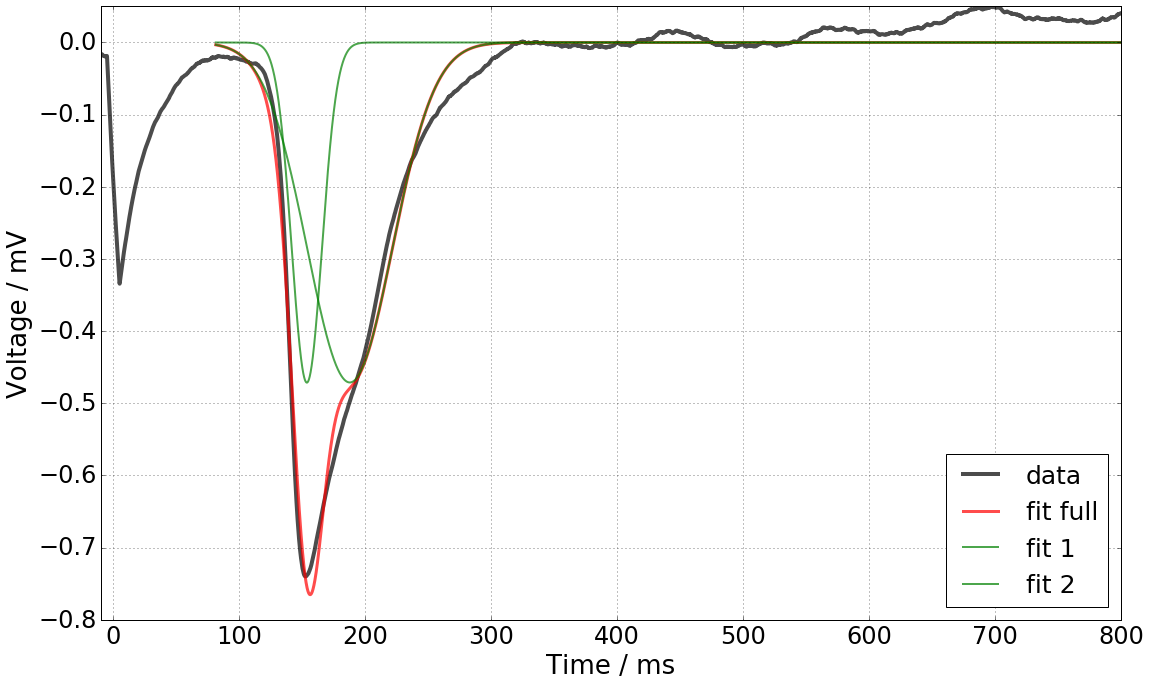

In [10]:
plt.figure(figsize=(15,9))

plt.plot(Xhot,Yhot,color='k',linewidth=4,alpha=0.7,label='data')
plt.plot(Xhot[CUT:],two_gaussians(Xhot[CUT:],*optim),'r',label='fit full',lw=3,alpha=0.7)


y1 = gaussian(Xhot[CUT:],*optim[0:3])
y2 = gaussian(Xhot[CUT:],*optim[3:6])
plt.plot(Xhot[CUT:],y1,'g',label='fit 1',lw=2,alpha=0.7)
plt.plot(Xhot[CUT:],y2,'g',label='fit 2',lw=2,alpha=0.7)
plt.xlim(-10,800)
plt.ylim(-0.8,0.05)
plt.grid()
plt.legend(loc='lower right',fontsize=25)
plt.tight_layout()
plt.xlabel(r'Time / ms',fontsize=26)
plt.ylabel('Voltage / mV',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

In [12]:
chisquare(Yhot[CUT:], f_exp=two_gaussians(Xhot[CUT:],*optim))

Power_divergenceResult(statistic=-7.8344877170839615e+92, pvalue=1.0)

In [13]:
E = two_gaussians(Xhot[CUT:],*optim)
O = Yhot[CUT:]
dof = 1#len(O)-1-6
chi = np.sum((O-E)**2/E)/dof
chi      

-7.8344877170839615e+92

In [14]:
def three_gaussians(x, h1, c1, w1,
                     h2, c2, w2,
                     h3, c3, w3):
    return (gaussian(x, h1, c1, w1) +
            gaussian(x, h2, c2, w2) +
            gaussian(x, h3, c3, w3))

def gauss_fit_vals_3(X,Y):
    minn = min(Y)
    MeanLoc = np.where(Y==minn)[0][0]
    Mean = X[MeanLoc]
    g1 = [minn,Mean,20]
    g2 = [minn*.6,Mean+100,20]
    g3 = [minn*.3,Mean+150,20]
    vals = g1+g2+g3
    return vals

def SignalCut(X,Y):
    TriggerTime = find_nearest(Xhot,0)
    Trigger     = np.where(Xhot==TriggerTime)[0][0]
    Cut = Trigger+100
    minPulseHold = find_nearest(Yhot,min(Yhot[2*Cut:]))
    minPulse     = np.where(Yhot==minPulseHold)[0][0]
    SignalCut = Cut + (minPulse-Cut)/2
    return SignalCut


CUT = SignalCut(Xhot,Yhot)
fitval = gauss_fit_vals_3(Xhot[CUT:],Yhot[CUT:])

errfunc = lambda p, x, y: (three_gaussians(x, *p) - y)**2
optim, success = optimize.leastsq(errfunc, fitval, args=(Xhot[CUT:],Yhot[CUT:]))
optim

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:29: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:32: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


array([ -4.71349982e-01,   1.53760961e+02,   1.19742000e+01,
        -4.71131602e-01,   1.87865145e+02,   3.37558373e+01,
        -8.83394563e-04,   3.31331535e+02,  -1.81809216e+00])

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:12: DeprecationWarning:

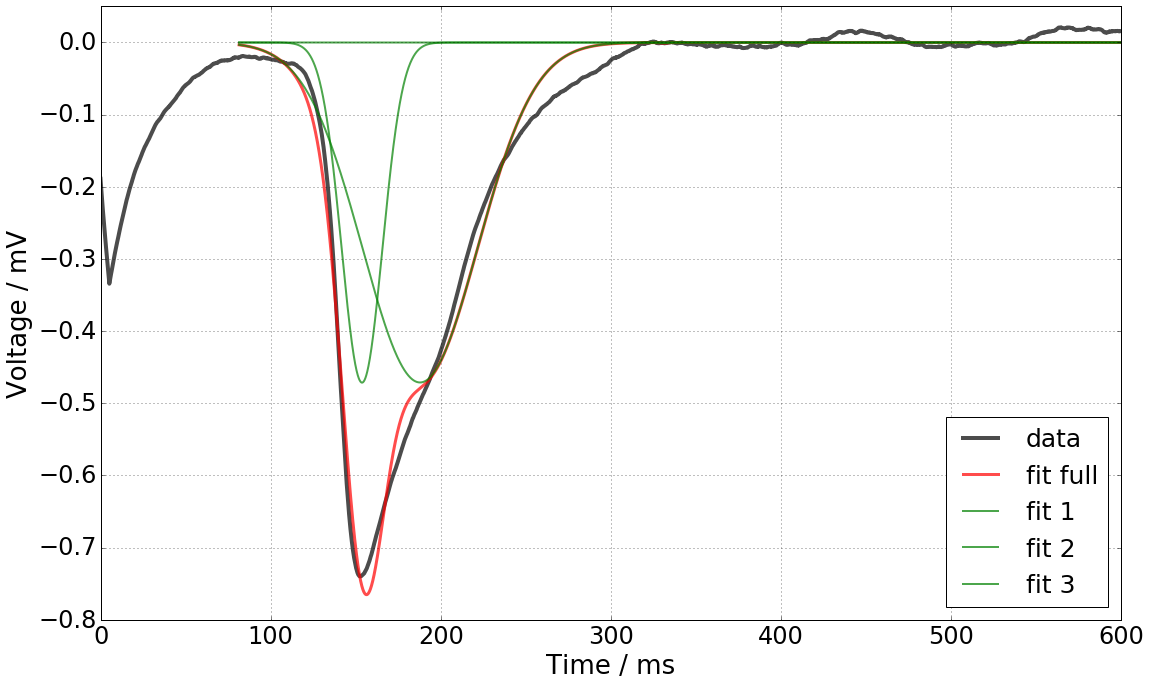

In [16]:
plt.figure(figsize=(15,9))

plt.plot(Xhot,Yhot,color='k',linewidth=4,alpha=0.7,label='data')
plt.plot(Xhot[CUT:],three_gaussians(Xhot[CUT:],*optim),'r',label='fit full',lw=3,alpha=0.7)


y1 = gaussian(Xhot[CUT:],*optim[0:3])
y2 = gaussian(Xhot[CUT:],*optim[3:6])
y3 = gaussian(Xhot[CUT:],*optim[6:9])

plt.plot(Xhot[CUT:],y1,'g',label='fit 1',lw=2,alpha=0.7)
plt.plot(Xhot[CUT:],y2,'g',label='fit 2',lw=2,alpha=0.7)
plt.plot(Xhot[CUT:],y3,'g',label='fit 3',lw=2,alpha=0.7)


plt.xlim(0,600)
plt.ylim(-0.8,0.05)
plt.grid()
plt.legend(loc='lower right',fontsize=25)
plt.tight_layout()
plt.xlabel(r'Time / ms',fontsize=26)
plt.ylabel('Voltage / mV',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

In [17]:
chisquare(Yhot[CUT:], f_exp=three_gaussians(Xhot[CUT:],*optim))

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


Power_divergenceResult(statistic=-7.874567375812728e+92, pvalue=1.0)

In [18]:
def four_gaussians(x, h1, c1, w1,
                      h2, c2, w2,
                      h3, c3, w3,
                      h4, c4, w4 ):
    return (gaussian(x, h1, c1, w1) +
            gaussian(x, h2, c2, w2) +
            gaussian(x, h3, c3, w3) +
            gaussian(x, h4, c4, w4) ) 

def gauss_fit_vals_4(X,Y):
    minn = min(Y)
    MeanLoc = np.where(Y==minn)[0][0]
    Mean = X[MeanLoc]
    g1 = [minn,Mean,20]
    g2 = [minn*.6,Mean+50,20]
    g3 = [minn*.3,Mean+75,20]
    g4 = [minn*.2,Mean+100,20]
    vals = g1+g2+g3+g4
    return vals

def SignalCut(X,Y):
    TriggerTime = find_nearest(Xhot,0)
    Trigger     = np.where(Xhot==TriggerTime)[0][0]
    Cut = Trigger+100
    minPulseHold = find_nearest(Yhot,min(Yhot[2*Cut:]))
    minPulse     = np.where(Yhot==minPulseHold)[0][0]
    SignalCut = Cut + (minPulse-Cut)/2
    return SignalCut


CUT = SignalCut(Xhot,Yhot)
fitval = gauss_fit_vals_4(Xhot[CUT:],Yhot[CUT:])

errfunc = lambda p, x, y: (four_gaussians(x, *p) - y)**2
optim, success = optimize.leastsq(errfunc, fitval, args=(Xhot[CUT:],Yhot[CUT:]))
optim

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:32: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:35: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


array([ -3.87573660e-01,   1.47654287e+02,   8.58597846e+00,
        -3.32965182e-01,   1.62218712e+02,   1.22598803e+01,
        -2.76847365e-01,   1.88674548e+02,   2.03518351e+01,
        -1.89828785e-01,   2.01834998e+02,   4.83362075e+01])

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:12: DeprecationWarning:

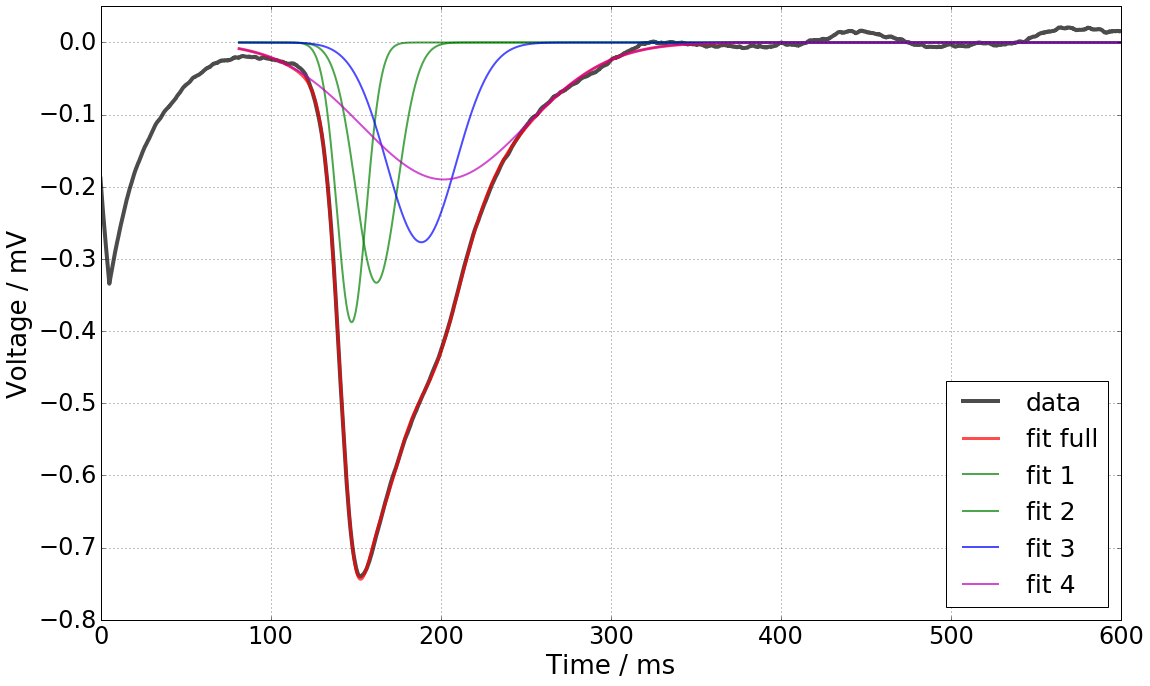

In [20]:
plt.figure(figsize=(15,9))

plt.plot(Xhot,Yhot,color='k',linewidth=4,alpha=0.7,label='data')
plt.plot(Xhot[CUT:],four_gaussians(Xhot[CUT:],*optim),'r',label='fit full',lw=3,alpha=0.7)


y1 = gaussian(Xhot[CUT:],*optim[0:3])
y2 = gaussian(Xhot[CUT:],*optim[3:6])
y3 = gaussian(Xhot[CUT:],*optim[6:9])
y4 = gaussian(Xhot[CUT:],*optim[9:12])

plt.plot(Xhot[CUT:],y1,'g',label='fit 1',lw=2,alpha=0.7)
plt.plot(Xhot[CUT:],y2,'g',label='fit 2',lw=2,alpha=0.7)
plt.plot(Xhot[CUT:],y3,'b',label='fit 3',lw=2,alpha=0.7)
plt.plot(Xhot[CUT:],y4,'m',label='fit 4',lw=2,alpha=0.7)


plt.xlim(0,600)
plt.ylim(-0.8,0.05)
plt.grid()
plt.legend(loc='lower right',fontsize=25)
plt.tight_layout()
plt.xlabel(r'Time / ms',fontsize=26)
plt.ylabel('Voltage / mV',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

In [21]:
chisquare(Yhot[CUT:], f_exp=four_gaussians(Xhot[CUT:],*optim))

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


Power_divergenceResult(statistic=-9.2004704692229856e+42, pvalue=1.0)

In [22]:
def five_gaussians(x, h1, c1, w1,
                      h2, c2, w2,
                      h3, c3, w3,
                      h4, c4, w4, 
                      h5, c5, w5):
    return (gaussian(x, h1, c1, w1) +
            gaussian(x, h2, c2, w2) +
            gaussian(x, h3, c3, w3) +
            gaussian(x, h4, c4, w4) +
            gaussian(x, h5, c5, w5)) 

def gauss_fit_vals_5(X,Y):
    minn = min(Y)
    MeanLoc = np.where(Y==minn)[0][0]
    Mean = X[MeanLoc]
    g1 = [minn,Mean,20]
    g2 = [minn*.6,Mean+50,20]
    g3 = [minn*.3,Mean+75,20]
    g4 = [minn*.2,Mean+100,20]
    g5 = [minn*.1,Mean+125,20]
    vals = g1+g2+g3+g4+g5
    return vals

def SignalCut(X,Y):
    TriggerTime = find_nearest(Xhot,0)
    Trigger     = np.where(Xhot==TriggerTime)[0][0]
    Cut = Trigger+100
    minPulseHold = find_nearest(Yhot,min(Yhot[2*Cut:]))
    minPulse     = np.where(Yhot==minPulseHold)[0][0]
    SignalCut = Cut + (minPulse-Cut)/2
    return SignalCut


CUT = SignalCut(Xhot,Yhot)
fitval = gauss_fit_vals_5(Xhot[CUT:],Yhot[CUT:])

errfunc = lambda p, x, y: (five_gaussians(x, *p) - y)**2
optim, success = optimize.leastsq(errfunc, fitval, args=(Xhot[CUT:],Yhot[CUT:]))
optim

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:35: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:38: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


array([ -3.44184475e-01,   1.47917498e+02,   7.99196612e+00,
        -2.53464640e-01,   1.61933712e+02,   1.18620549e+01,
        -4.69033120e-01,   1.85779314e+02,  -3.15274130e+01,
        -3.75161142e-02,   2.45357014e+02,  -1.12942408e+01,
        -5.42736224e-02,   2.74121944e+02,   1.96703049e+01])

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning:

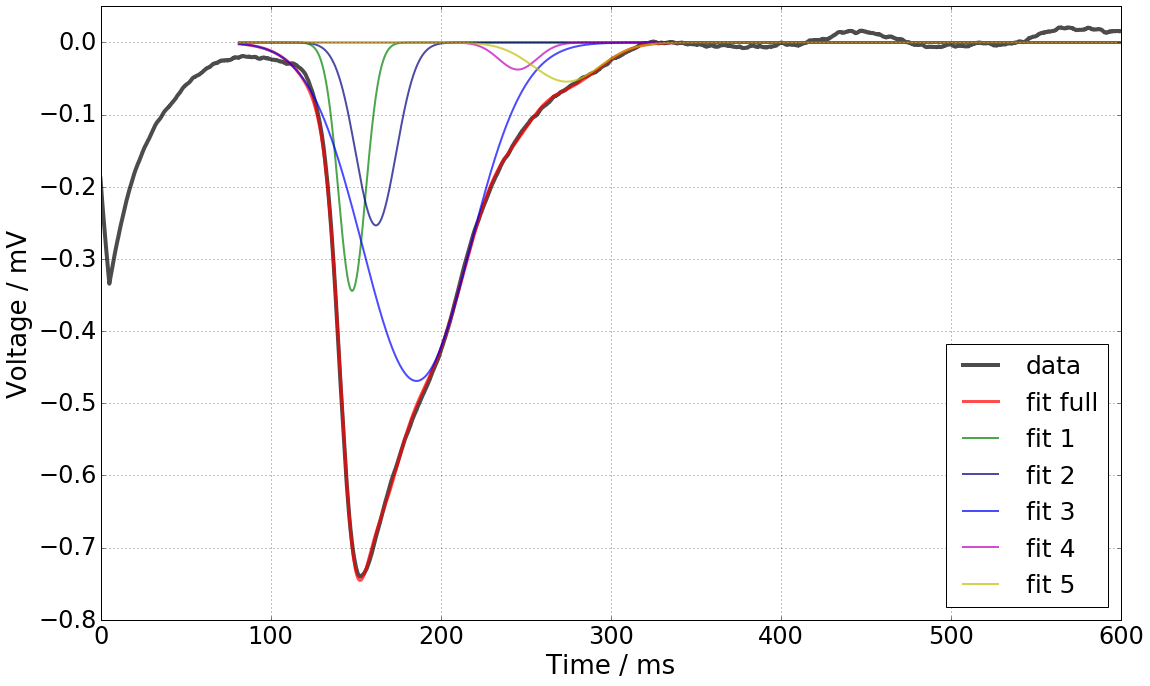

In [24]:
plt.figure(figsize=(15,9))

plt.plot(Xhot,Yhot,color='k',linewidth=4,alpha=0.7,label='data')
plt.plot(Xhot[CUT:],five_gaussians(Xhot[CUT:],*optim),'r',label='fit full',lw=3,alpha=0.7)


y1 = gaussian(Xhot[CUT:],*optim[0:3])
y2 = gaussian(Xhot[CUT:],*optim[3:6])
y3 = gaussian(Xhot[CUT:],*optim[6:9])
y4 = gaussian(Xhot[CUT:],*optim[9:12])
y5 = gaussian(Xhot[CUT:],*optim[12:15])

plt.plot(Xhot[CUT:],y1,'g',label='fit 1',lw=2,alpha=0.7)
plt.plot(Xhot[CUT:],y2,'navy',label='fit 2',lw=2,alpha=0.7)
plt.plot(Xhot[CUT:],y3,'b',label='fit 3',lw=2,alpha=0.7)
plt.plot(Xhot[CUT:],y4,'m',label='fit 4',lw=2,alpha=0.7)
plt.plot(Xhot[CUT:],y5,'y',label='fit 5',lw=2,alpha=0.7)


plt.xlim(0,600)
plt.ylim(-0.8,0.05)
plt.grid()
plt.legend(loc='lower right',fontsize=25)
plt.tight_layout()
plt.xlabel(r'Time / ms',fontsize=26)
plt.ylabel('Voltage / mV',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

In [25]:
chisquare(Yhot[CUT:], f_exp=five_gaussians(Xhot[CUT:],*optim))

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


Power_divergenceResult(statistic=-2.7290138582279987e+107, pvalue=1.0)

In [26]:
def six_gaussians(x, h1, c1, w1,
                      h2, c2, w2,
                      h3, c3, w3,
                      h4, c4, w4, 
                      h5, c5, w5,
                      h6, c6, w6):
    return (gaussian(x, h1, c1, w1) +
            gaussian(x, h2, c2, w2) +
            gaussian(x, h3, c3, w3) +
            gaussian(x, h4, c4, w4) +
            gaussian(x, h5, c5, w5) +
            gaussian(x, h6, c6, w6)) 

def gauss_fit_vals_6(X,Y):
    minn = min(Y)
    MeanLoc = np.where(Y==minn)[0][0]
    Mean = X[MeanLoc]
    g1 = [minn,Mean,20]
    g2 = [minn*.6,Mean+50,20]
    g3 = [minn*.3,Mean+75,20]
    g4 = [minn*.2,Mean+100,20]
    g5 = [minn*.1,Mean+125,20]
    g6 = [minn*.1,Mean+150,20]
    vals = g1+g2+g3+g4+g5+g6
    return vals

def SignalCut(X,Y):
    TriggerTime = find_nearest(Xhot,0)
    Trigger     = np.where(Xhot==TriggerTime)[0][0]
    Cut = Trigger+100
    minPulseHold = find_nearest(Yhot,min(Yhot[2*Cut:]))
    minPulse     = np.where(Yhot==minPulseHold)[0][0]
    SignalCut = Cut + (minPulse-Cut)/2
    return SignalCut


CUT = SignalCut(Xhot,Yhot)
fitval = gauss_fit_vals_6(Xhot[CUT:],Yhot[CUT:])

errfunc = lambda p, x, y: (six_gaussians(x, *p) - y)**2
optim, success = optimize.leastsq(errfunc, fitval, args=(Xhot[CUT:],Yhot[CUT:]))
optim

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:38: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:41: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


array([ -3.28260723e-01,   1.49349171e+02,   8.32768487e+00,
        -6.03225148e-01,   1.69450932e+02,   2.18510961e+01,
        -7.07147559e-02,   1.94110505e+02,   6.26916104e+00,
        -1.50585127e-01,   2.07010647e+02,   9.47320281e+00,
        -7.87322261e-02,   2.59210600e+02,   2.59044465e+01,
        -1.42859982e-01,   2.25734033e+02,   1.49366596e+01])

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning:

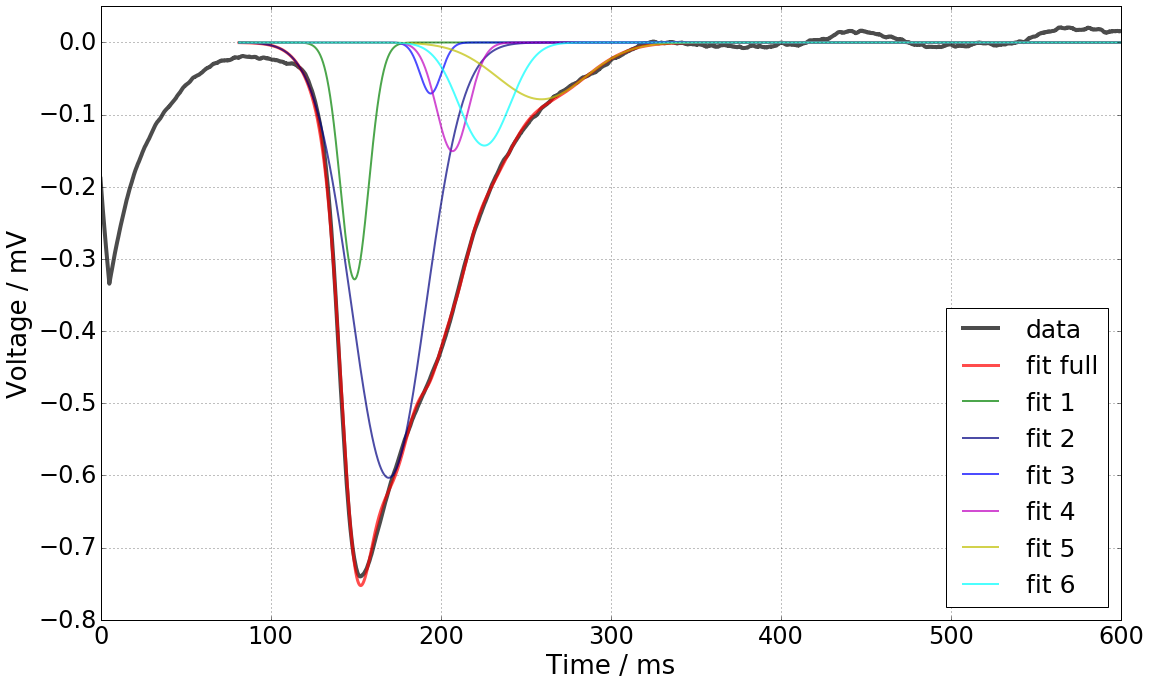

In [27]:
plt.figure(figsize=(15,9))

plt.plot(Xhot,Yhot,color='k',linewidth=4,alpha=0.7,label='data')
plt.plot(Xhot[CUT:],six_gaussians(Xhot[CUT:],*optim),'r',label='fit full',lw=3,alpha=0.7)


y1 = gaussian(Xhot[CUT:],*optim[0:3])
y2 = gaussian(Xhot[CUT:],*optim[3:6])
y3 = gaussian(Xhot[CUT:],*optim[6:9])
y4 = gaussian(Xhot[CUT:],*optim[9:12])
y5 = gaussian(Xhot[CUT:],*optim[12:15])
y6 = gaussian(Xhot[CUT:],*optim[15:18])


plt.plot(Xhot[CUT:],y1,'g',label='fit 1',lw=2,alpha=0.7)
plt.plot(Xhot[CUT:],y2,'navy',label='fit 2',lw=2,alpha=0.7)
plt.plot(Xhot[CUT:],y3,'b',label='fit 3',lw=2,alpha=0.7)
plt.plot(Xhot[CUT:],y4,'m',label='fit 4',lw=2,alpha=0.7)
plt.plot(Xhot[CUT:],y5,'y',label='fit 5',lw=2,alpha=0.7)
plt.plot(Xhot[CUT:],y6,'aqua',label='fit 6',lw=2,alpha=0.7)


plt.xlim(0,600)
plt.ylim(-0.8,0.05)
plt.grid()
plt.legend(loc='lower right',fontsize=25)
plt.tight_layout()
plt.xlabel(r'Time / ms',fontsize=26)
plt.ylabel('Voltage / mV',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

In [28]:
chisquare(Yhot[CUT:], f_exp=six_gaussians(Xhot[CUT:],*optim))

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


Power_divergenceResult(statistic=-1.0607857958060863e+129, pvalue=1.0)

In [ ]:
TriggerTime = find_nearest(Xhot,0)
Trigger     = np.where(Xhot==TriggerTime)[0][0]
Cut = Trigger+100

minPulseHold = find_nearest(Yhot,min(Yhot[2*Cut:]))
minPulse     = np.where(Yhot==minPulseHold)[0][0]

SignalCut = Cut + (minPulse-Cut)/2


def gaussian(x, height, center, width):
    return height*np.exp(-(x - center)**2/(2*width**2))

def two_gaussians(x, h1, c1, w1,
                  h2, c2, w2):
    return (gaussian(x, h1, c1, w1) +
            gaussian(x, h2, c2, w2) )

def gauss_fit_vals(X,Y):
    minn = min(Y)
    MeanLoc = np.where(Y==minn)[0][0]
    Mean = X[MeanLoc]
    vals = [minn,Mean,20,minn*.6,Mean+100,20]
    return vals

def SignalCut(X,Y):
    TriggerTime = find_nearest(Xhot,0)
    Trigger     = np.where(Xhot==TriggerTime)[0][0]
    Cut = Trigger+100
    minPulseHold = find_nearest(Yhot,min(Yhot[2*Cut:]))
    minPulse     = np.where(Yhot==minPulseHold)[0][0]
    SignalCut = Cut + (minPulse-Cut)/2
    return SignalCut

errfunc = lambda p, x, y: (two_gaussians(x, *p) - y)**2
x = Xhot[eh:]
y = Yhot[eh:]

fitval = gauss_fit_vals(x,y)

optim, success = optimize.leastsq(errfunc, fitval, args=(x, y))
optim

In [ ]:
CUT = SignalCut(Xhot,Yhot)
fitval = gauss_fit_vals(Xhot[CUT:],Yhot[CUT:])

errfunc = lambda p, x, y: (two_gaussians(x, *p) - y)**2
optim, success = optimize.leastsq(errfunc, fitval, args=(Xhot[CUT:],Yhot[CUT:]))
optim

In [ ]:
def gauss_fit_vals(X,Y):
    minn = min(Y)
    MeanLoc = np.where(Y==minn)[0][0]
    Mean = dataX[MeanLoc]
    vals = [minn,Mean,20,minn*.6,Mean+100,20]
    return vals

In [ ]:
plt.plot(Xhot[eh:3*eh],abs(Yhot[eh:3*eh]),color='steelblue',linewidth=2)

In [ ]:
def gaussian(x, height, center, width, offset):
    return height*np.exp(-(x - center)**2/(2*width**2)) + offset

def six_gaussians(x, h1, c1, w1,
                  h2, c2, w2, 
                  h3, c3, w3,
                  h4, c4, w4,
                  h5, c5, w5,
                  h6, c6, w6,
                  offset):
    
    return (gaussian(x, h1, c1, w1, offset=0) +
        gaussian(x, h2, c2, w2, offset=0) +
        gaussian(x, h3, c3, w3, offset=0) + 
        gaussian(x, h4, c4, w4, offset=0) + 
        gaussian(x, h5, c5, w5, offset=0) + 
        gaussian(x, h6, c6, w6, offset=0) + 
        offset)


def gaussian(x, height, center, width):
    return height*np.exp(-(x - center)**2/(2*width**2))

def two_gaussians(x, h1, c1, w1,
                  h2, c2, w2):
    return (gaussian(x, h1, c1, w1) +
            gaussian(x, h2, c2, w2) )

In [ ]:
x = np.arange(100)
y1 = gaussian(x,1,20,5)
y2 = gaussian(x,0.5,30,5)
y = y1+y2

p0 = [1,15,5,0.5,50,5]
popt, pcov = curve_fit(two_gaussians, x,y,p0=p0)
popt

plt.plot(x,y)
plt.plot(x,y1,color='b')
plt.plot(x,y2,color='b')

plt.plot(x,two_gaussians(x,*popt),color='r')

In [ ]:
errfunc = lambda p, x, y: (two_gaussians(x, *p) - y)**2
x = Xhot[eh:3*eh]
y = abs(Yhot[eh:3*eh])
y = Yhot[eh:3*eh]

optim, success = optimize.leastsq(errfunc, p0, args=(x, y))
optim

In [ ]:
x = Xhot[eh:3*eh]
y = abs(Yhot[eh:3*eh])
yy = abs(Yhot[eh:3*eh])
yy[yy<0.05]=0
#p0 = [0.4,240,20,.2,300,20]
popt, pcov = curve_fit(two_gaussians, x,yy)
popt

In [ ]:
plt.plot(x,two_gaussians(x,*optim),'r',label='fit')
yy = abs(Yhot[eh:3*eh])
#yy[yy<0.05]=0
plt.plot(Xhot[eh:3*eh],Yhot[eh:3*eh],color='steelblue',linewidth=2)



In [ ]:
optim[0:3]
optim[3:6]

In [ ]:
plt.figure(figsize=(15,9))

x = Xhot[eh:]
y = Yhot[eh:]
optim, success = optimize.leastsq(errfunc, p0, args=(x, y))

plt.plot(Xhot,Yhot,color='k',linewidth=4,alpha=0.7,label='data')
plt.plot(x,two_gaussians(x,*optim),'r',label='fit full',lw=3,alpha=0.7)


y1 = gaussian(x,*optim[0:3])
y2 = gaussian(x,*optim[3:6])
plt.plot(x,y1,'g',label='fit 1',lw=2,alpha=0.7)
plt.plot(x,y2,'g',label='fit 2',lw=2,alpha=0.7)
plt.xlim(-10,800)
plt.ylim(-0.4,0.05)
plt.grid()
plt.legend(loc='lower right',fontsize=25)
plt.tight_layout()
plt.xlabel(r'Time / ms',fontsize=26)
plt.ylabel('Voltage / mV',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

In [ ]:
x = Xhot[eh:3*eh]
y = abs(Yhot[eh:3*eh])
p0 = [0.3,250,20,.15,300,20]
popt, pcov = curve_fit(two_gaussians, x,yy*100)
popt

In [ ]:
plt.plot(Xhot[eh:3*eh],abs(Yhot[eh:3*eh])>0.05 = 0,color='steelblue',linewidth=2)

In [ ]:
yy = abs(Yhot[eh:3*eh])
yy[yy>0.5]=0